### Gaussian process

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
np.set_printoptions(precision=2)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rc('xtick',labelsize=5); plt.rc('ytick',labelsize=5)
print ("Ready.")

Ready.


### Kernel function

In [2]:
def kernel_se(x1,x2,hyp={'gain':1.0,'len':1.0}):
    """ Squared-exponential kernel function """
    D = distance.cdist(x1/hyp['len'],x2/hyp['len'],'sqeuclidean')
    K = hyp['gain']*np.exp(-D)
    return K
def gp_sampler(times=np.linspace(start=0.0,stop=1.0,num=100).reshape((-1,1)), # [L x 1]
               hyp_gain=1.0,hyp_len=1.0,meas_std=1e-8,n_traj=1):
    L = times.shape[0]
    K = kernel_se(times,times,hyp={'gain':hyp_gain,'len':hyp_len}) # [L x L]
    K_chol = np.linalg.cholesky(K+1e-8*np.eye(L,L)) # [L x L]
    traj = K_chol @ np.random.randn(L,n_traj) # [L x n_traj]
    traj = traj + meas_std*np.random.randn(*traj.shape)
    return traj
def get_gamma(times=np.linspace(start=0.0,stop=1.0,num=100).reshape((-1,1)), # [L x 1]
              hyp_len=1.0,meas_std=1e-8):
    """
        RKHS projection
    """
    L = times.shape[0]
    K = kernel_se(times,times,hyp={'gain':1.0,'len':hyp_len}) # [L x L]
    Gamma = K @ np.linalg.inv(K + meas_std*np.eye(L,L)) # [L x L]
    return Gamma
print ("Ready.")

Ready.


### Plot sampled trajectories with different hyper-parameters

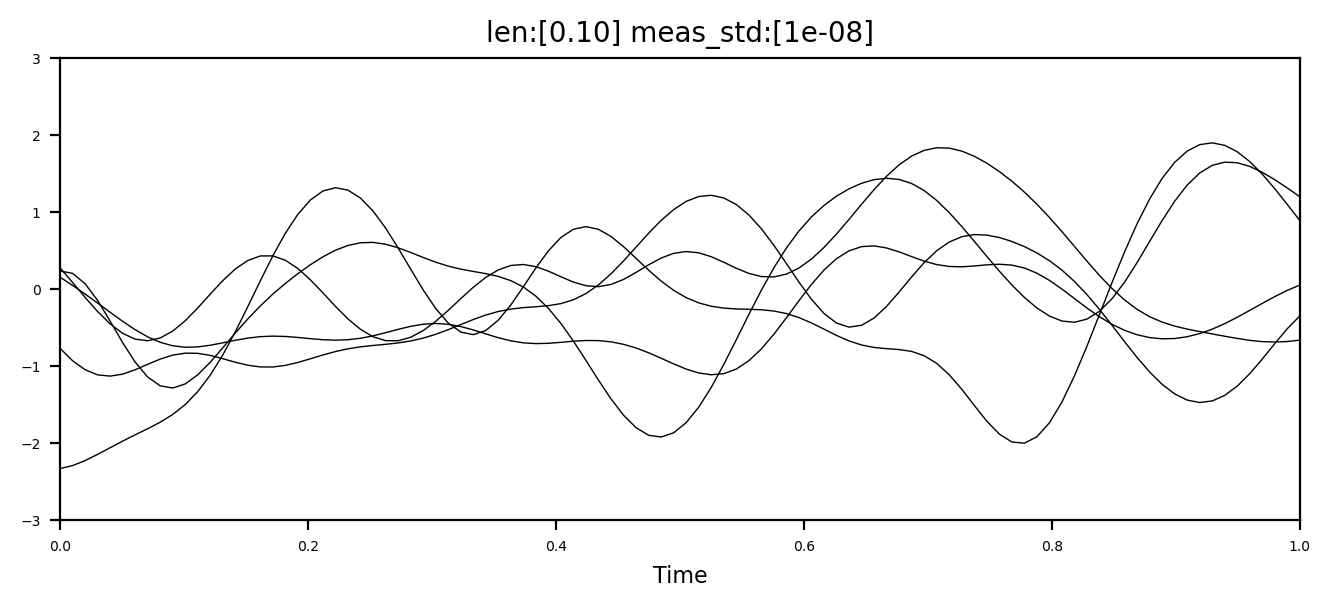

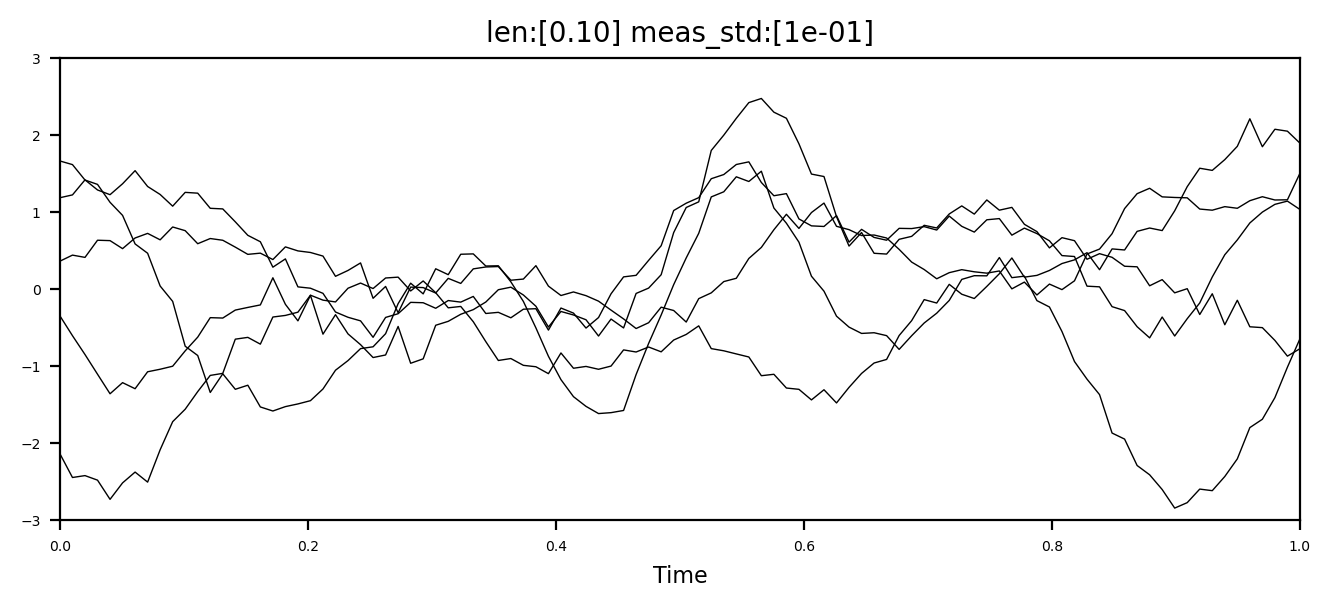

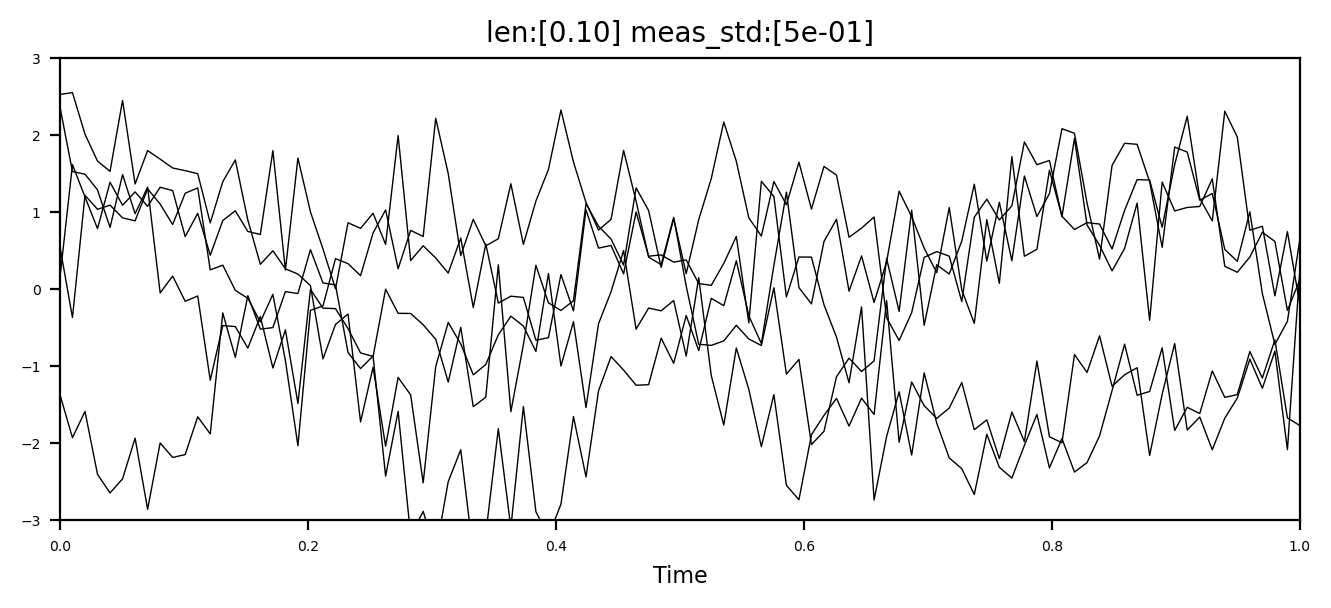

In [3]:
L = 100
times = np.linspace(start=0.0,stop=1.0,num=L).reshape((-1,1)) # [L x 1]
for hyp_len,meas_std in [(0.1,1e-8),(0.1,1e-1),(0.1,5e-1)]:
    # Sample trajectories
    n_traj = 5
    trajs = gp_sampler(
        times=times,hyp_gain=1.0,hyp_len=hyp_len,meas_std=meas_std,n_traj=n_traj) # [L x n_traj]
    # Plot sampled trajectories
    plt.figure(figsize=(8,3))
    plt.plot(times,trajs,ls='-',color='k',lw=1/2)
    plt.xlim([0.0,1.0]); plt.ylim([-3.0,+3.0])
    plt.xlabel('Time',fontsize=8); 
    plt.title('len:[%.2f] meas_std:[%.e]'%(hyp_len,meas_std),fontsize=10); plt.show()

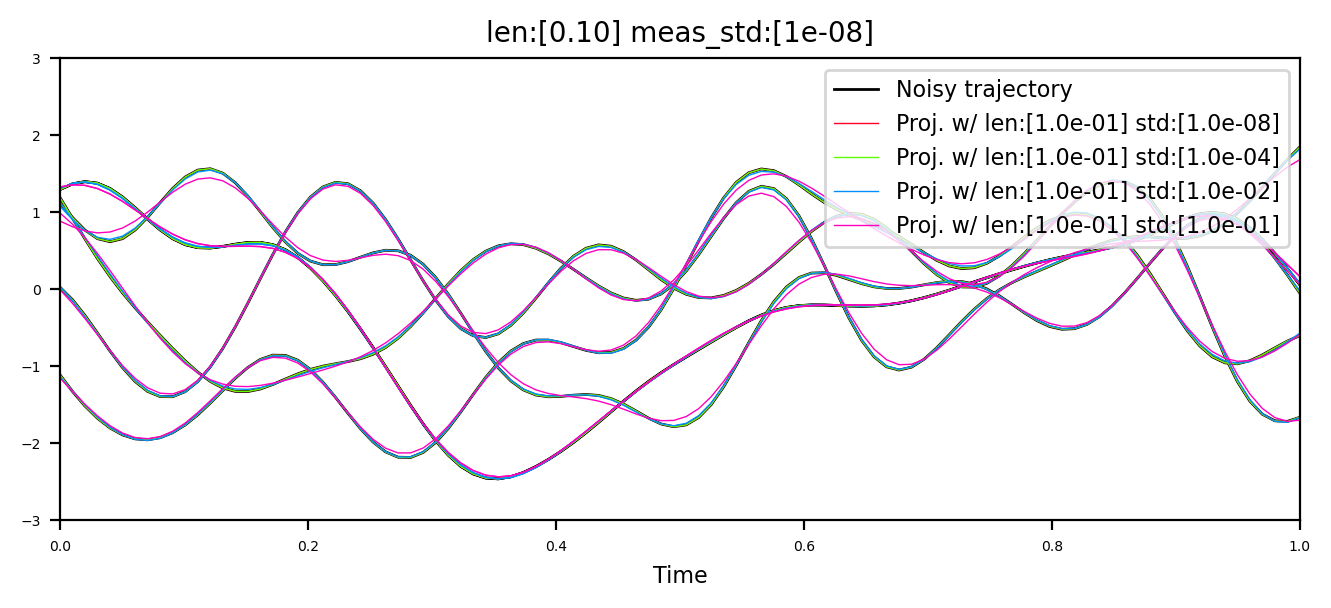

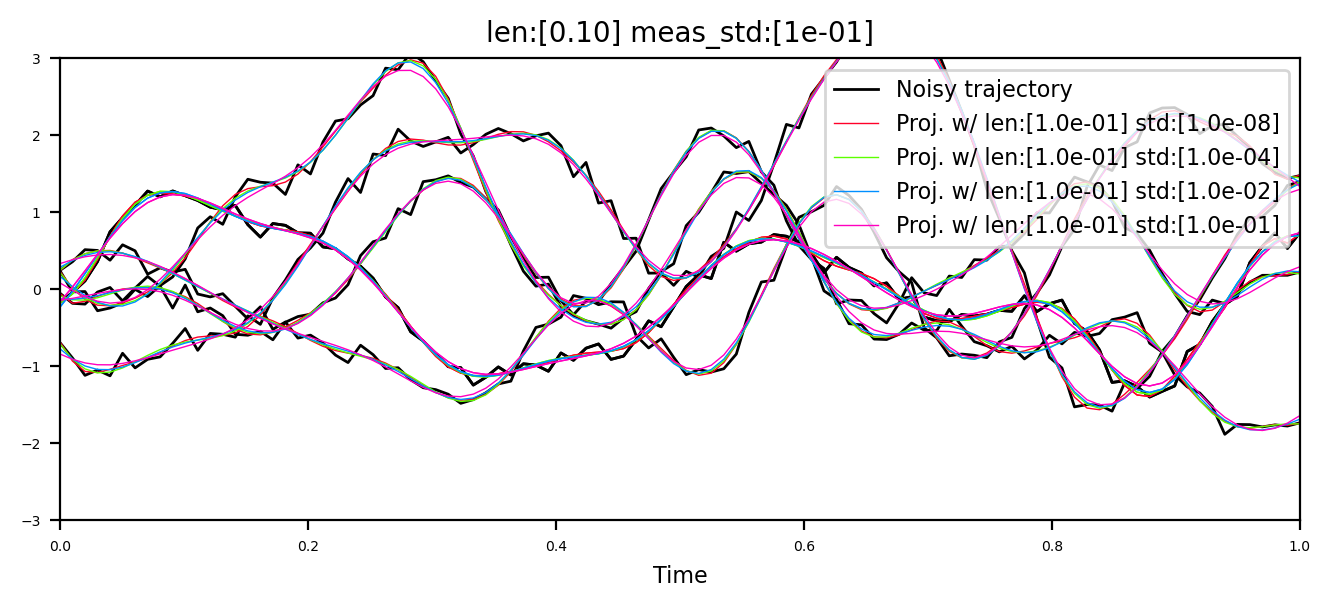

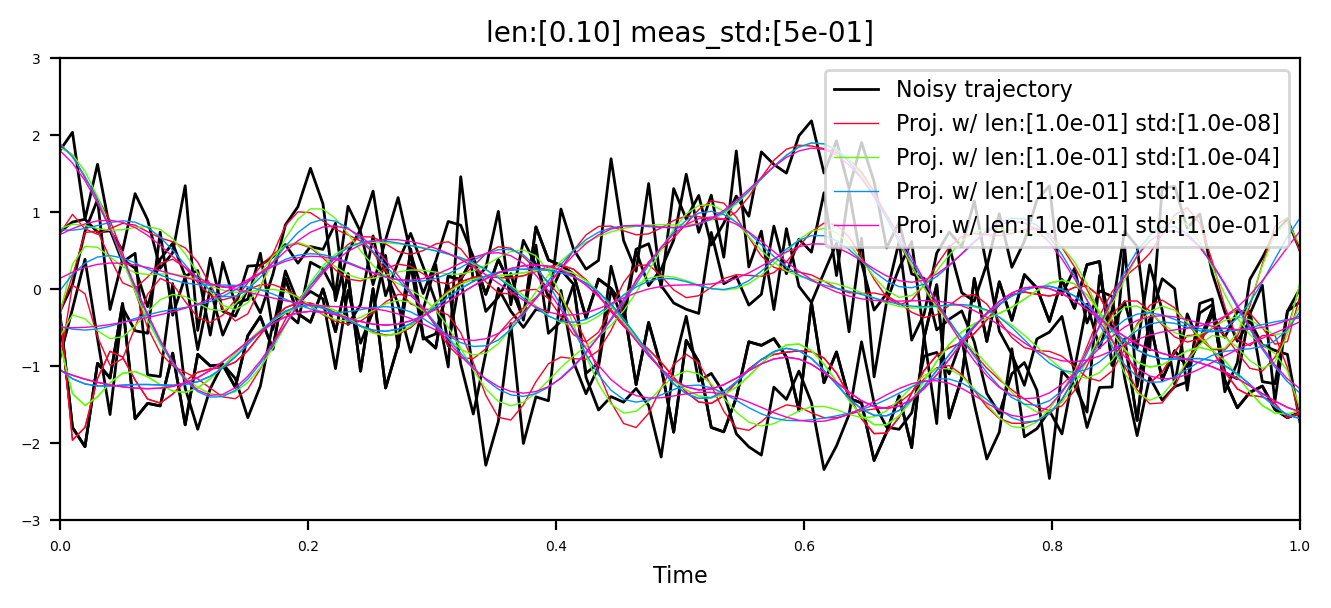

In [22]:
L = 100
times = np.linspace(start=0.0,stop=1.0,num=L).reshape((-1,1)) # [L x 1]
for hyp_len,meas_std in [(0.1,1e-8),(0.1,1e-1),(0.1,5e-1)]:
    # Sample trajectories
    n_traj = 5
    trajs = gp_sampler(
        times=times,hyp_gain=1.0,hyp_len=hyp_len,meas_std=meas_std,n_traj=n_traj) # [L x n_traj]
    # Project
    hyp_len_proj = 0.1
    meas_std_projs = [1e-8,1e-4,1e-2,1e-1]
    trajs_projs = []
    for meas_std_proj in meas_std_projs:
        gamma = get_gamma(times=times,hyp_len=hyp_len_proj,meas_std=meas_std_proj) # [L x L]
        trajs_projs.append(gamma @ trajs)
    # Plot sampled trajectories
    plt.figure(figsize=(8,3))
    plt.plot(times[:,0],trajs[:,0],ls='-',color='k',lw=1,label='Noisy trajectory')
    plt.plot(times,trajs,ls='-',color='k',lw=1)
    colors = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,len(meas_std_projs))]
    for traj_idx,meas_std_proj in enumerate(meas_std_projs):
        trajs_proj = trajs_projs[traj_idx]
        plt.plot(times[:,0],trajs_proj[:,0],
                 ls='-',color=colors[traj_idx],lw=1/2,
                 label='Proj. w/ len:[%.1e] std:[%.1e]'%(hyp_len_proj,meas_std_proj))
        plt.plot(times,trajs_proj,ls='-',color=colors[traj_idx],lw=1/2)
    plt.xlim([0.0,1.0]); plt.ylim([-3.0,+3.0])
    plt.xlabel('Time',fontsize=8); plt.legend(fontsize=8,loc='upper right')
    plt.title('len:[%.2f] meas_std:[%.e]'%(hyp_len,meas_std),fontsize=10); plt.show()